# When Demand Isn’t the Problem: Fragility and Stability in NYC Taxi Congestion

This project analyzes congestion dynamics in the New York City taxi marketplace using 2018 NYC TLC trip data. Rather than treating congestion as a function of demand alone, the analysis frames the system as operating in distinct regimes, including periods of structural breakdown that are not explained by peak demand. It develops a zone-level fragility metric using Empirical Bayes estimation and evaluates targeted supply interventions through a counterfactual simulation. Results highlight a fundamental tradeoff between efficiency-oriented and stability-oriented policies.

---

## Motivation

Urban transportation systems often exhibit nonlinear behavior: severe congestion can occur even outside peak demand periods and may persist in specific locations. Traditional demand-based interventions optimize average system performance but may fail to stabilize structurally fragile regions of the network.

This project asks:

- When does the taxi marketplace fail?
- Which zones are persistently fragile?
- How should limited supply interventions be targeted under capacity constraints?

---

## Data

- **Source:** NYC Taxi & Limousine Commission (TLC)
- **Period:** January–December 2018
- **Granularity:** Zone–hour observations
- **Key variables:** trip counts, trip distance, trip duration, pickup location

Taxi zones are joined using the official TLC zone lookup and shapefile for spatial context.

---

## Methodology

### 1. Market State Characterization
- Construct zone–hour measures of demand and congestion (minutes per mile)
- Visualize the demand–congestion phase space
- Identify heterogeneous behavior inconsistent with a single capacity curve

### 2. Regime Classification
- Classify zone–hour observations into operating regimes (e.g., normal, high demand, breakdown)
- Treat breakdown states as qualitatively distinct system failures rather than extreme demand realizations

### 3. Fragility Estimation
- Compute zone-level breakdown frequency
- Apply Empirical Bayes shrinkage to estimate persistent breakdown propensity
- Compare citywide and regionally pooled priors to improve stability of estimates

### 4. Counterfactual Policy Simulation
Supply interventions are modeled as multiplicative reductions in congestion during targeted regimes:

### 5. Targeting Strategies
Three targeting strategies are evaluated under identical budgets:
- **Demand-based:** highest average demand
- **Empirical Bayes (EB):** highest estimated fragility
- **Random:** null benchmark

### 6. Evaluation Metrics
Policies are evaluated across multiple objectives:
- Demand-weighted average congestion (efficiency)
- Global congestion tail risk
- Fragility-weighted congestion improvement
- Tail risk reduction within fragile zones

---

## Key Findings

- Congestion is not driven by demand alone; extreme congestion occurs across a wide range of demand levels.
- Demand-based targeting maximizes average efficiency but provides limited benefit to fragile zones.
- EB-based targeting substantially reduces extreme congestion in structurally fragile zones.
- Random targeting underperforms informed strategies except at very large budgets.
- No single policy dominates across objectives, revealing a clear efficiency–stability tradeoff.

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, Dict, List, Tuple, Optional, Sequence
from __future__ import annotations

%matplotlib inline

In [3]:
DATA_DIR = Path("data/raw")

cols_to_keep = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "trip_distance",
    "fare_amount"
]

parquet_files = sorted(DATA_DIR.glob("*.parquet"))

df_raw = pd.concat(
    (pd.read_parquet(f, columns=cols_to_keep, engine="pyarrow")
     for f in parquet_files),
    ignore_index=True
)

df_raw.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount
0,2018-01-01 00:21:05,2018-01-01 00:24:23,41,24,0.5,4.5
1,2018-01-01 00:44:55,2018-01-01 01:03:05,239,140,2.7,14.0
2,2018-01-01 00:08:26,2018-01-01 00:14:21,262,141,0.8,6.0
3,2018-01-01 00:20:22,2018-01-01 00:52:51,140,257,10.2,33.5
4,2018-01-01 00:09:18,2018-01-01 00:27:06,246,239,2.5,12.5


In [4]:
def clean_data(
    df: pd.DataFrame,
    min_duration_min: float = 1.0,
    max_duration_min: float = 120.0,
    min_distance_mi: float = 0.1,
    max_distance_mi: Optional[float] = None
) -> pd.DataFrame:

    out = df.copy()

    # Datetime coercion
    out["tpep_pickup_datetime"] = pd.to_datetime(out["tpep_pickup_datetime"], errors="coerce")
    out["tpep_dropoff_datetime"] = pd.to_datetime(out["tpep_dropoff_datetime"], errors="coerce")

    # Feature engineering
    out["trip_duration_min"] = (out["tpep_dropoff_datetime"] - out["tpep_pickup_datetime"]).dt.total_seconds() / 60.0

    # Basic cleaning mask
    m = (
        out["trip_duration_min"].between(min_duration_min, max_duration_min, inclusive="both")
        & (out["trip_distance"] > min_distance_mi)
    )
    if max_distance_mi is not None:
        m &= out["trip_distance"] <= max_distance_mi

    # Apply cleaning
    out = out[m].copy()

    # Derived "stress" proxy
    out["minutes_per_mile"] = out["trip_duration_min"] / out["trip_distance"]

    # Hour bucket for aggregation
    out["hour"] = out["tpep_pickup_datetime"].dt.floor("h")

    return out

df_clean = clean_data(df_raw)
df_clean.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,trip_duration_min,minutes_per_mile,hour
0,2018-01-01 00:21:05,2018-01-01 00:24:23,41,24,0.5,4.5,3.300000,6.600000,2018-01-01
1,2018-01-01 00:44:55,2018-01-01 01:03:05,239,140,2.7,14.0,18.166667,6.728395,2018-01-01
2,2018-01-01 00:08:26,2018-01-01 00:14:21,262,141,0.8,6.0,5.916667,7.395833,2018-01-01
3,2018-01-01 00:20:22,2018-01-01 00:52:51,140,257,10.2,33.5,32.483333,3.184641,2018-01-01
4,2018-01-01 00:09:18,2018-01-01 00:27:06,246,239,2.5,12.5,17.800000,7.120000,2018-01-01


## Regime Discovery

A regime is a recurring system state characterized by similar demand intensity and congestion behavior, with meaningfully different performance outcomes.

- Normal: low–moderate demand, stable congestion
- Peak: high demand, rapidly rising congestion
- Breakdown: congestion disproportionately high relative to demand

### City-Wide Aggregation

In [5]:
city_hourly = (
    df_clean
    .groupby("hour")
    .agg(
        demand_trips=("minutes_per_mile", "size"),
        avg_congestion=("minutes_per_mile", "mean"),
        p90_congestion=("minutes_per_mile", lambda s: s.quantile(0.90)),
    )
    .reset_index()
)

city_hourly.head()

,hour,demand_trips,avg_congestion,p90_congestion
0,2001-01-01 00:00:00,4,8.855654,10.617824
1,2001-01-01 22:00:00,1,14.989293,14.989293
2,2001-01-05 11:00:00,1,4.379085,4.379085
3,2002-12-31 21:00:00,1,7.832080,7.832080
4,2002-12-31 22:00:00,1,3.891185,3.891185


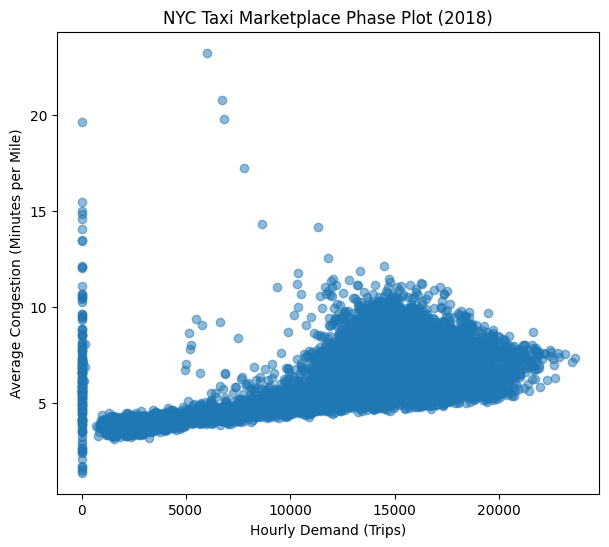

In [6]:
plt.figure(figsize=(7, 6))
plt.scatter(
    city_hourly["demand_trips"],
    city_hourly["avg_congestion"],
    alpha=0.5
)
plt.xlabel("Hourly Demand (Trips)")
plt.ylabel("Average Congestion (Minutes per Mile)")
plt.title("NYC Taxi Marketplace Phase Plot (2018)")
plt.show()


> Figure 1. Each point represents a zone–hour observation, plotting hourly demand against average congestion (minutes per mile). While most activity lies in a stable operating regime where congestion increases gradually with demand, the figure reveals substantial heterogeneity: severe congestion can occur even at low or moderate demand levels, and extreme congestion events appear as outliers across the demand spectrum. This pattern indicates that congestion is not driven by demand alone and motivates a regime-based, zone-level analysis focused on structural fragility and tail risk rather than average system behavior.

In [7]:
# Define quantile-based regimes
demand_hi = city_hourly["demand_trips"].quantile(0.75)
cong_hi = city_hourly["avg_congestion"].quantile(0.75)

def assign_regime(row):
    if row["demand_trips"] < demand_hi and row["avg_congestion"] < cong_hi:
        return "Normal"
    elif row["demand_trips"] >= demand_hi and row["avg_congestion"] < cong_hi:
        return "High Demand"
    elif row["demand_trips"] < demand_hi and row["avg_congestion"] >= cong_hi:
        return "Congestion"
    else:
        return "Breakdown"

city_hourly["regime"] = city_hourly.apply(assign_regime, axis=1)


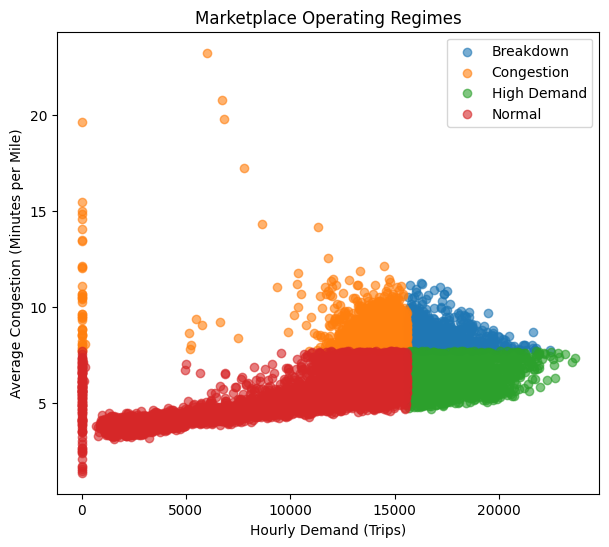

In [8]:
plt.figure(figsize=(7, 6))

for r, g in city_hourly.groupby("regime"):
    plt.scatter(
        g["demand_trips"],
        g["avg_congestion"],
        label=r,
        alpha=0.6
    )

plt.xlabel("Hourly Demand (Trips)")
plt.ylabel("Average Congestion (Minutes per Mile)")
plt.title("Marketplace Operating Regimes")
plt.legend()
plt.show()


> Figure 2. Zone–hour observations are colored by inferred operating regime based on demand and congestion thresholds. Most observations fall within a stable operating regime characterized by moderate congestion and rising demand. However, a distinct subset of observations enters high-congestion and breakdown regimes, which are not confined to peak demand levels. This regime structure highlights nonlinear system behavior and motivates treating breakdown states as qualitatively different from normal operations rather than as simple extensions of peak demand.

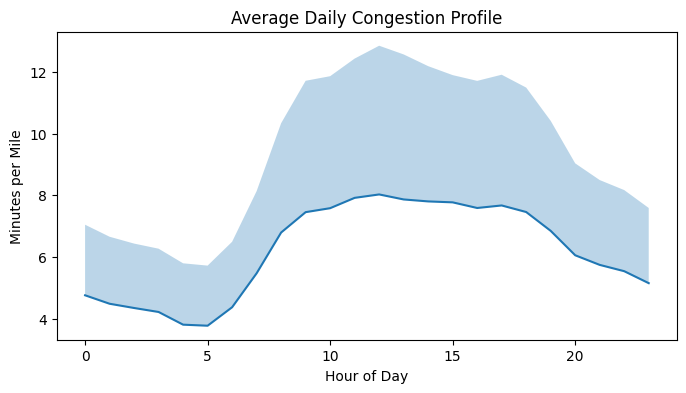

In [9]:
city_hourly["hour_of_day"] = city_hourly["hour"].dt.hour

hourly_profile = (
    city_hourly
    .groupby("hour_of_day")
    .agg(
        avg_congestion=("avg_congestion", "mean"),
        p90_congestion=("p90_congestion", "mean"),
    )
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.plot(hourly_profile["hour_of_day"], hourly_profile["avg_congestion"])
plt.fill_between(
    hourly_profile["hour_of_day"],
    hourly_profile["avg_congestion"],
    hourly_profile["p90_congestion"],
    alpha=0.3
)

plt.xlabel("Hour of Day")
plt.ylabel("Minutes per Mile")
plt.title("Average Daily Congestion Profile")
plt.show()


> Figure 3. Average congestion (minutes per mile) follows a clear diurnal pattern, with pronounced morning and evening peaks corresponding to commuter traffic. Despite this regular structure, peak congestion levels alone do not explain the most extreme congestion events observed in the system, indicating that time-of-day effects capture typical load patterns but not localized or structural failures. This motivates complementing temporal analysis with zone-level fragility measures.

### Zone-level Aggregation

In [10]:
def aggregate_zone_hourly(
    df: pd.DataFrame,
    zone_col: str = "PULocationID",
    time_col: str = "hour",
    stress_col: str = "minutes_per_mile",
    quantiles: Sequence[float] = (0.90, 0.95),
    min_trips_per_zone_hour: int = 5,
) -> pd.DataFrame:
    """
    Aggregate cleaned TLC data to (zone, hour) with marketplace/system metrics.

    Expected input (from clean_data):
      - df[time_col] exists (hourly bucket)
      - df[stress_col] exists (minutes_per_mile)
      - df[zone_col] exists (e.g., PULocationID)

    Metrics:
      - demand_trips: count of trips (proxy for realized demand)
      - avg_congestion: mean minutes_per_mile (proxy for supply stress / congestion)
      - qXX_congestion: specified quantiles of minutes_per_mile (tail stress)

    Parameters
    ----------
    zone_col : "PULocationID" (default) or "DOLocationID"
    time_col : "hour" (default)
    stress_col : "minutes_per_mile" (default)
    quantiles : quantiles to compute for tail stress (e.g., (0.9, 0.95))
    min_trips_per_zone_hour : drop (zone, hour) bins with fewer trips than this

    Returns
    -------
    pd.DataFrame with columns:
      [zone_col, time_col, demand_trips, avg_congestion, q90_congestion, ...]
    """
    required = {zone_col, time_col, stress_col}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(
            f"aggregate_zone_hourly missing required columns: {sorted(missing)}. "
            f"Did you run clean_data() first?"
        )

    # Build aggregation spec
    agg = {
        "demand_trips": (stress_col, "size"),
        "avg_congestion": (stress_col, "mean"),
    }

    # Quantiles become q90_congestion, q95_congestion, etc.
    for q in quantiles:
        q_name = f"q{int(round(q * 100)):02d}_congestion"
        agg[q_name] = (stress_col, lambda s, q=q: s.quantile(q))

    out = (
        df.groupby([zone_col, time_col], observed=True)
          .agg(**agg)
          .reset_index()
    )

    # Remove ultra-sparse bins (reduces noisy tails)
    if min_trips_per_zone_hour > 1:
        out = out[out["demand_trips"] >= min_trips_per_zone_hour].copy()

    return out

zone_hourly = aggregate_zone_hourly(df_clean)
zone_hourly.head()

,PULocationID,hour,demand_trips,avg_congestion,q90_congestion,q95_congestion
1216,3,2018-08-10 11:00:00,5,6.174313,9.647119,9.840226
1805,4,2018-01-01 00:00:00,85,5.873998,8.174035,8.813421
1806,4,2018-01-01 01:00:00,153,5.968313,8.277193,8.755585
1807,4,2018-01-01 02:00:00,150,5.628559,8.142819,10.001488
1808,4,2018-01-01 03:00:00,99,5.448004,8.003268,8.761905


In [11]:
# Add hourly city-level data to zone-level for reference/adjustment
zone_hourly = zone_hourly.merge(
    city_hourly[["hour", "regime"]],
    on="hour",
    how="left"
)

# Aggregate across zone IDs
zone_regime_summary = (
    zone_hourly
    .groupby("PULocationID")
    .agg(
        total_hours=("hour", "nunique"),
        breakdown_hours=("regime", lambda x: (x == "Breakdown").sum()),
        avg_demand=("demand_trips", "mean"),
        avg_congestion=("avg_congestion", "mean"),
    )
    .reset_index()
)

# Annotate breakdown metric
zone_regime_summary["breakdown_propensity"] = (
    zone_regime_summary["breakdown_hours"] /
    zone_regime_summary["total_hours"]
)

zone_regime_summary.head()

,PULocationID,total_hours,breakdown_hours,avg_demand,avg_congestion,breakdown_propensity
0,3,1,0,5.000000,6.174313,0.000000
1,4,8301,777,25.174798,6.017905,0.093603
2,7,8628,755,18.290102,5.286323,0.087506
3,8,2,1,5.000000,7.848058,0.500000
4,9,1,0,5.000000,5.193426,0.000000


In [12]:
# Look at the most-fragile zones with the added requirement of
# more than 20 hours of service (otherwise 1hr zones dominate)
top_fragile = (
    zone_regime_summary[zone_regime_summary["total_hours"] > 20]
    .sort_values("breakdown_propensity", ascending=False)
    .head(15)
)

top_fragile


,PULocationID,total_hours,breakdown_hours,avg_demand,avg_congestion,breakdown_propensity
38,54,28,11,5.642857,6.229685,0.392857
89,123,30,10,5.400000,6.780521,0.333333
126,165,53,17,5.622642,5.740898,0.320755
202,257,23,7,5.434783,5.103338,0.304348
184,235,37,9,5.783784,5.154219,0.243243
149,194,106,23,10.933962,5.012140,0.216981
49,69,85,17,5.800000,5.960794,0.200000
70,92,32,6,5.312500,4.352518,0.187500
36,51,58,10,5.810345,3.831960,0.172414
8,14,130,20,5.900000,4.669191,0.153846


In [13]:
# Mapping file toa dd metadata to zones
zone_map = pd.read_csv("data/raw/NYC_Taxi_Zones_20260114.csv")
zone_map.head()

,Shape Geometry,Shape Length,Shape Area,Zone,Location ID,Borough
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.116357,0.000782,Newark Airport,1,EWR
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.433470,0.004866,Jamaica Bay,2,Queens
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.043567,0.000112,Alphabet City,4,Manhattan
4,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.092146,0.000498,Arden Heights,5,Staten Island


In [14]:
zone_regime_summary = zone_regime_summary.merge(
    zone_map,
    left_on="PULocationID",
    right_on="Location ID",
    how="left"
).sort_values("breakdown_propensity")

zone_regime_summary[["PULocationID","avg_demand","avg_congestion","breakdown_propensity"]].head()

,PULocationID,avg_demand,avg_congestion,breakdown_propensity
0,3,5.000000,6.174313,0.0
113,147,5.333333,4.945388,0.0
93,126,5.000000,3.192080,0.0
87,118,5.000000,5.908835,0.0
86,117,5.000000,3.935509,0.0


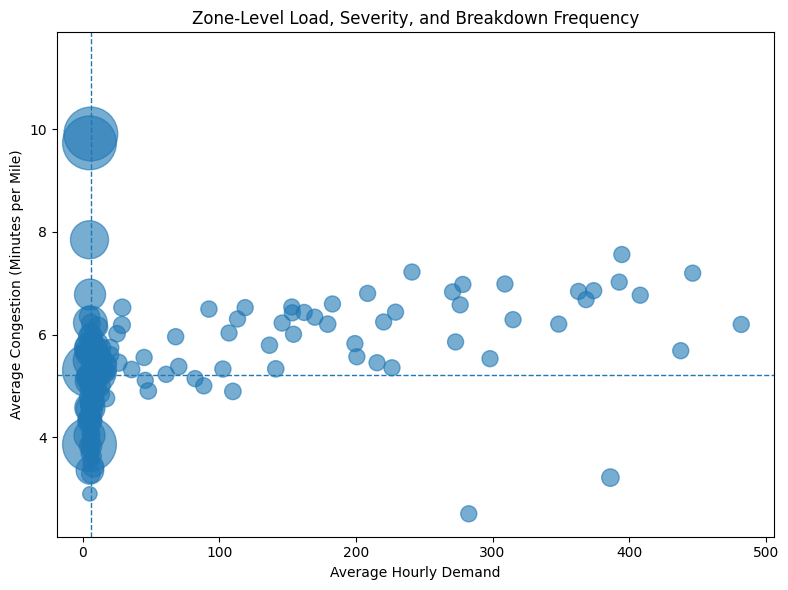

In [15]:
plt.figure(figsize=(8, 6))

plt.scatter(
    zone_regime_summary["avg_demand"],
    zone_regime_summary["avg_congestion"],
    s=zone_regime_summary["breakdown_propensity"] * 1500,
    alpha=0.6
)

plt.xlabel("Average Hourly Demand")
plt.ylabel("Average Congestion (Minutes per Mile)")
plt.title("Zone-Level Load, Severity, and Breakdown Frequency")

plt.axvline(zone_regime_summary["avg_demand"].median(), linestyle="--", linewidth=1)
plt.axhline(zone_regime_summary["avg_congestion"].median(), linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


> Figure 4. Each bubble represents a taxi zone, positioned by average demand and average congestion, with bubble size reflecting breakdown frequency (or estimated fragility). Zones with similar demand levels exhibit markedly different breakdown behavior, indicating that structural characteristics—not demand alone—drive system instability. This heterogeneity motivates targeted interventions that account for persistent fragility rather than uniform demand-based policies.

## Empirical Bayes

To stabilize zone-level fragility estimates and avoid noise-driven extremes in low-exposure zones (low total hours or average hourly demand), I apply an Empirical Bayes model that shrinks raw breakdown rates toward a citywide prior. This produces more reliable rankings while preserving true heterogeneity among high-exposure zones.

In [16]:
p_hat = zone_regime_summary["breakdown_propensity"]

p_mean = p_hat.mean()
p_var = p_hat.var(ddof=1)

# Guard against degenerate variance
eps = 1e-6
p_var = max(p_var, eps)

common_factor = (p_mean * (1 - p_mean) / p_var) - 1

# Estimate alpha and beta correction factors
alpha = p_mean * common_factor
beta = (1 - p_mean) * common_factor

# Update breakdown_propensity
zone_regime_summary["breakdown_propensity_eb"] = (
    (zone_regime_summary["breakdown_hours"] + alpha) /
    (zone_regime_summary["total_hours"] + alpha + beta)
)

In [17]:
zone_regime_summary[
    ["total_hours", "breakdown_propensity", "breakdown_propensity_eb"]
].sort_values("total_hours").head(10)

,total_hours,breakdown_propensity,breakdown_propensity_eb
0,1,0.0,0.084180
91,1,1.0,0.312151
159,1,1.0,0.312151
143,1,1.0,0.312151
17,1,0.0,0.084180
4,1,0.0,0.084180
19,1,0.0,0.084180
9,1,0.0,0.084180
136,1,0.0,0.084180
140,1,0.0,0.084180


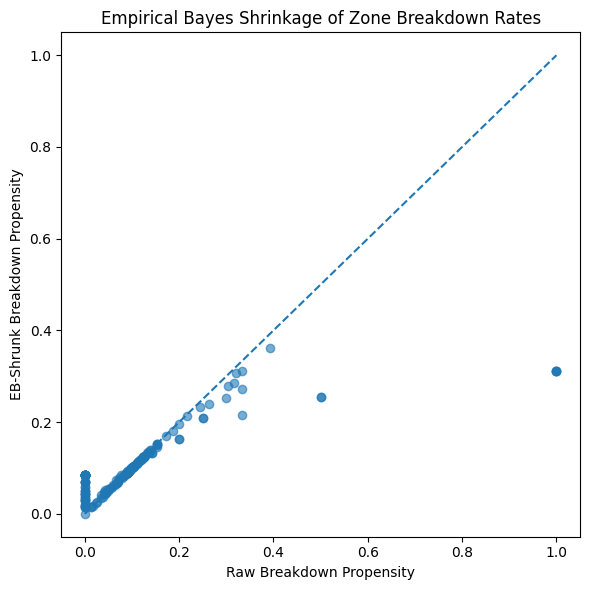

In [18]:
plt.figure(figsize=(6, 6))

plt.scatter(
    zone_regime_summary["breakdown_propensity"],
    zone_regime_summary["breakdown_propensity_eb"],
    alpha=0.6
)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Raw Breakdown Propensity")
plt.ylabel("EB-Shrunk Breakdown Propensity")
plt.title("Empirical Bayes Shrinkage of Zone Breakdown Rates")

plt.tight_layout()
plt.show()


> Figure 5. Shrinkage of zone breakdown rates based on EB shows a typical pattern, where extreme values are pulled toward the global mean, adjusted for the amount of supporting evidence. Points along the y=x line represent values largely unadjusted by EB.

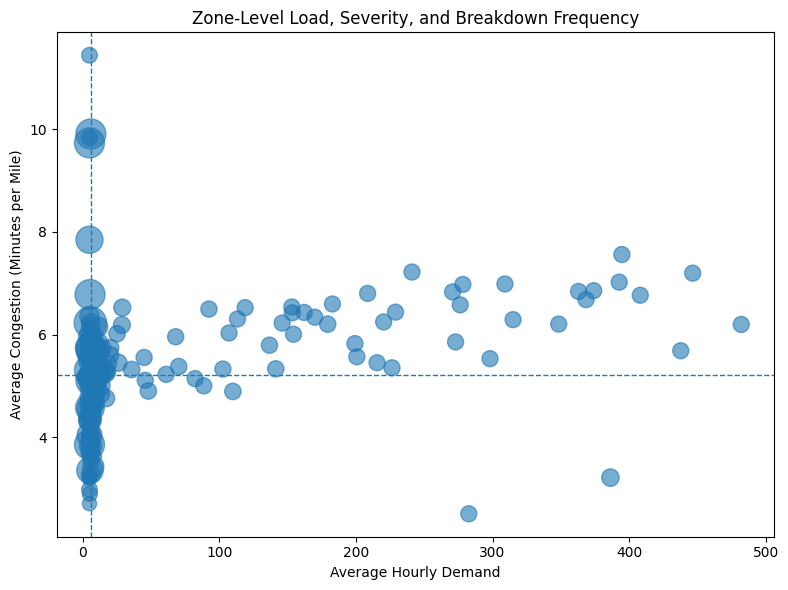

In [19]:
plt.figure(figsize=(8, 6))

plt.scatter(
    zone_regime_summary["avg_demand"],
    zone_regime_summary["avg_congestion"],
    s=zone_regime_summary["breakdown_propensity_eb"] * 1500,
    alpha=0.6
)

plt.xlabel("Average Hourly Demand")
plt.ylabel("Average Congestion (Minutes per Mile)")
plt.title("Zone-Level Load, Severity, and Breakdown Frequency")

plt.axvline(zone_regime_summary["avg_demand"].median(), linestyle="--", linewidth=1)
plt.axhline(zone_regime_summary["avg_congestion"].median(), linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

> Figure 6. Like the prior bubble plot, each bubble represents a taxi zone, positioned by average demand and average congestion, with bubble size reflecting breakdown frequency (or estimated fragility). We can see the effect of EB shrinkage on the high-contestion, low-demand zones (i.e. the fragile zones with high breakdown rate). True to its behavior, we see that the application of EB shrinkage reduced the size of the high-congestion, low-demand zones which can be thought of as "extreme measurements with low evidence," potentially providing a "truer" estimation of breakdown for those regions.

## Implementation of Breakdown Targeting Policy

We want to stabilize the system when it’s failing (i.e. breakdown status). Assume adding supply reduces minutes-per-mile by a factor with diminishing returns:

- new_congestion = old_congestion * (1 - η * s)

Where:

- s = supply increase (e.g., 0.10 for +10%)
- η = effectiveness (0 to 1; you can sensitivity-test it)

Ideally, targeting only the most fragile zones based on EB estimation of breakdown propensity, but should also compare with alternative strategies.

In practice, supply interventions are operationally constrained: only a limited number of zones can be targeted at once due to fleet size, staffing, or dispatch limitations. As such, we will simulate the selection of K zones for intervention across a range of values.

### Simulation

In [20]:
def demand_weighted_mean(df: pd.DataFrame, value_col: str, weight_col: str = "demand_trips") -> float:
    w = df[weight_col].to_numpy()
    x = df[value_col].to_numpy()
    if w.sum() == 0:
        return float("nan")
    return float(np.sum(w * x) / np.sum(w))

def fragility_weighted_improvement(
    zone_hourly_cf,
    zone_regime_summary,
    fragility_col="breakdown_propensity_eb",
    eval_regimes=("Breakdown",),
    base_col="avg_congestion",
    cf_col="avg_congestion_cf",
):
    # Merge EB fragility onto zone-hour table
    z = zone_hourly_cf.merge(
        zone_regime_summary[["PULocationID", fragility_col]],
        on="PULocationID",
        how="left"
    ).copy()

    # Evaluate only selected regimes
    z = z[z["regime"].isin(set(eval_regimes))].copy()

    # Weight = fragility * demand
    w = z[fragility_col].to_numpy() * z["demand_trips"].to_numpy()
    if np.sum(w) == 0:
        return np.nan

    base = np.sum(w * z[base_col].to_numpy()) / np.sum(w)
    cf = np.sum(w * z[cf_col].to_numpy()) / np.sum(w)

    return 100 * (base - cf) / base

def fragile_zone_tail_improvement(
    zone_hourly_cf,
    zone_regime_summary,
    fragility_col="breakdown_propensity_eb",
    top_frac=0.20,
    tail_q=0.95,
    eval_regimes=("Breakdown",),
    base_col="avg_congestion",
    cf_col="avg_congestion_cf",
):
    """
    Improvement in tail congestion (e.g. p95) restricted to top fragile zones.
    """
    cutoff = float(zone_regime_summary[fragility_col].quantile(1 - top_frac))
    fragile_zones = set(zone_regime_summary.loc[
        zone_regime_summary[fragility_col] >= cutoff, "PULocationID"
    ])

    z = zone_hourly_cf[
        zone_hourly_cf["PULocationID"].isin(fragile_zones) &
        zone_hourly_cf["regime"].isin(set(eval_regimes))
    ].copy()

    if len(z) == 0:
        return np.nan

    base = float(z[base_col].quantile(tail_q))
    cf = float(z[cf_col].quantile(tail_q))

    return 100.0 * (base - cf) / base if base else np.nan

def build_target_sets(
    zone_regime_summary: pd.DataFrame,
    k: int,
    score_col_eb: str = "breakdown_propensity_eb",
    min_hours: int = 0,
    random_seed: int = 42,
) -> Dict[str, List[int]]:
    """
    Return dict of target zone lists for each strategy:
      - 'EB'     : top-k by EB fragility score
      - 'Demand' : top-k by avg_demand
      - 'Random' : random k from eligible zones
    """
    required = {"PULocationID", "avg_demand", "total_hours", score_col_eb}
    missing = required - set(zone_regime_summary.columns)
    if missing:
        raise KeyError(f"zone_regime_summary missing columns: {sorted(missing)}")

    eligible = zone_regime_summary[zone_regime_summary["total_hours"] >= min_hours].copy()
    if len(eligible) < k:
        raise ValueError(f"Not enough eligible zones ({len(eligible)}) for k={k}. Lower k or min_hours.")

    zones_eb = (
        eligible.sort_values(score_col_eb, ascending=False)
        .head(k)["PULocationID"]
        .astype(int)
        .tolist()
    )
    zones_demand = (
        eligible.sort_values("avg_demand", ascending=False)
        .head(k)["PULocationID"]
        .astype(int)
        .tolist()
    )

    rng = np.random.default_rng(random_seed)
    zones_random = (
        pd.Series(rng.choice(eligible["PULocationID"].to_numpy(), size=k, replace=False))
        .astype(int)
        .tolist()
    )

    return {"EB": zones_eb, "Demand": zones_demand, "Random": zones_random}

@dataclass(frozen=True)
class PolicyParams:
    k: int
    supply_boost: float         # e.g. 0.10 for +10% supply
    eta: float                  # effectiveness multiplier, e.g. 0.50
    regimes: Tuple[str, ...]    # regimes where policy is applied, e.g. ("Breakdown",)
    min_hours: int = 0          # eligibility filter for targeting lists
    random_seed: int = 42       # reproducible random baseline

def apply_policy(
    zone_hourly: pd.DataFrame,
    target_zones: Sequence[int],
    supply_boost: float,
    eta: float,
    regimes: Sequence[str],
    value_col: str = "avg_congestion",
    out_col: str = "avg_congestion_cf",
) -> pd.DataFrame:
    """
    Apply policy as multiplicative improvement to congestion for targeted zones during specified regimes:
      new = old * (1 - eta * supply_boost)

    Returns a copy with a new column out_col.
    """
    required = {"PULocationID", "regime", value_col}
    missing = required - set(zone_hourly.columns)
    if missing:
        raise KeyError(f"zone_hourly missing columns: {sorted(missing)}")

    df = zone_hourly.copy()
    df[out_col] = df[value_col]

    regimes_set = set(regimes)
    mask = df["PULocationID"].isin(target_zones) & df["regime"].isin(regimes_set)

    # clip to avoid negative congestion if someone tries huge parameters
    factor = max(0.0, 1.0 - eta * supply_boost)
    df.loc[mask, out_col] = df.loc[mask, value_col] * factor

    return df

def evaluate_policy(
    zone_hourly_cf: pd.DataFrame,
    eval_regimes: Sequence[str] = ("Breakdown",),
    base_col: str = "avg_congestion",
    cf_col: str = "avg_congestion_cf",
) -> Dict[str, float]:
    """
    Evaluate within eval_regimes using demand-weighted mean and tail metrics.
    """
    required = {"regime", "demand_trips", base_col, cf_col}
    missing = required - set(zone_hourly_cf.columns)
    if missing:
        raise KeyError(f"zone_hourly_cf missing columns: {sorted(missing)}")

    eval_df = zone_hourly_cf[zone_hourly_cf["regime"].isin(set(eval_regimes))].copy()

    base_dw = demand_weighted_mean(eval_df, base_col, "demand_trips")
    cf_dw = demand_weighted_mean(eval_df, cf_col, "demand_trips")

    # Tail metrics (unweighted): you can also compute demand-weighted tails later if desired
    p90_base = float(eval_df[base_col].quantile(0.90))
    p90_cf = float(eval_df[cf_col].quantile(0.90))
    p95_base = float(eval_df[base_col].quantile(0.95))
    p95_cf = float(eval_df[cf_col].quantile(0.95))

    return {
        "baseline_dw_mean": base_dw,
        "cf_dw_mean": cf_dw,
        "dw_mean_improvement_pct": 100.0 * (base_dw - cf_dw) / base_dw if base_dw and not np.isnan(base_dw) else float("nan"),
        "p90_base": p90_base,
        "p90_cf": p90_cf,
        "p90_improvement_pct": 100.0 * (p90_base - p90_cf) / p90_base if p90_base else float("nan"),
        "p95_base": p95_base,
        "p95_cf": p95_cf,
        "p95_improvement_pct": 100.0 * (p95_base - p95_cf) / p95_base if p95_base else float("nan"),
        "n_rows_eval": float(len(eval_df)),
    }

def run_one_scenario(
    zone_hourly: pd.DataFrame,
    zone_regime_summary: pd.DataFrame,
    params: PolicyParams,
    score_col_eb: str = "breakdown_propensity_eb",
    eval_regimes: Sequence[str] = ("Breakdown",),
) -> pd.DataFrame:
    """
    Runs EB vs Demand vs Random for a single parameter scenario and returns a tidy results DataFrame.
    """
    target_sets = build_target_sets(
        zone_regime_summary=zone_regime_summary,
        k=params.k,
        score_col_eb=score_col_eb,
        min_hours=params.min_hours,
        random_seed=params.random_seed,
    )

    rows = []
    for strategy, zones in target_sets.items():
        zcf = apply_policy(
            zone_hourly=zone_hourly,
            target_zones=zones,
            supply_boost=params.supply_boost,
            eta=params.eta,
            regimes=params.regimes,
        )

        metrics = evaluate_policy(zcf, eval_regimes=eval_regimes)

        metrics["fragility_weighted_improvement_pct"] = fragility_weighted_improvement(
            zone_hourly_cf=zcf,
            zone_regime_summary=zone_regime_summary,
            fragility_col=score_col_eb,
            eval_regimes=eval_regimes,
            base_col="avg_congestion",
            cf_col="avg_congestion_cf",
        )

        metrics["fragile_zone_p95_improvement_pct"] = fragile_zone_tail_improvement(
            zone_hourly_cf=zcf,
            zone_regime_summary=zone_regime_summary,
            fragility_col=score_col_eb,
            top_frac=0.20,
            tail_q=0.95,
            eval_regimes=eval_regimes,
            base_col="avg_congestion",
            cf_col="avg_congestion_cf",
        )

        rows.append({
            "strategy": strategy,
            "k": params.k,
            "supply_boost": params.supply_boost,
            "eta": params.eta,
            "apply_regimes": ",".join(params.regimes),
            "eval_regimes": ",".join(eval_regimes),
            "min_hours": params.min_hours,
            "random_seed": params.random_seed,
            **metrics
        })

    return pd.DataFrame(rows)

def run_grid(
    zone_hourly: pd.DataFrame,
    zone_regime_summary: pd.DataFrame,
    k_values: Sequence[int] = (10, 20, 30),
    supply_boost_values: Sequence[float] = (0.05, 0.10, 0.20),
    eta_values: Sequence[float] = (0.25, 0.50, 0.75),
    apply_regimes_list: Sequence[Sequence[str]] = (("Breakdown",), ("Peak", "Breakdown")),
    min_hours: int = 1000,
    random_seed: int = 42,
    score_col_eb: str = "breakdown_propensity_eb",
    eval_regimes: Sequence[str] = ("Breakdown",),
) -> pd.DataFrame:
    """
    Runs a grid of scenarios and returns a tidy results table.
    """
    out = []
    for k in k_values:
        for sb in supply_boost_values:
            for eta in eta_values:
                for regs in apply_regimes_list:
                    params = PolicyParams(
                        k=k,
                        supply_boost=float(sb),
                        eta=float(eta),
                        regimes=tuple(regs),
                        min_hours=min_hours,
                        random_seed=random_seed,
                    )
                    out.append(
                        run_one_scenario(
                            zone_hourly=zone_hourly,
                            zone_regime_summary=zone_regime_summary,
                            params=params,
                            score_col_eb=score_col_eb,
                            eval_regimes=eval_regimes,
                        )
                    )
    return pd.concat(out, ignore_index=True)


In [ ]:
# Run demand improvement simulations
results = run_grid(
    zone_hourly=zone_hourly,
    zone_regime_summary=zone_regime_summary,
    k_values=(10, 20, 40),
    supply_boost_values=(0.05, 0.10, 0.20),
    eta_values=(0.25, 0.50, 0.75),
    apply_regimes_list=(("Breakdown",), ("High Demand", "Breakdown")),
    min_hours=100,
    random_seed=42,
    score_col_eb="breakdown_propensity_eb",
    eval_regimes=("Breakdown",),
)

results.pivot_table(
    index=["k","supply_boost","eta","apply_regimes"],
    columns="strategy",
    values=[
        "dw_mean_improvement_pct",
        "p95_improvement_pct",
        "fragility_weighted_improvement_pct",
        "fragile_zone_p95_improvement_pct",
    ],
    aggfunc="mean"
).round(3)

dw_mean_improvement_pct         \
strategy                                                    Demand     EB   
k  supply_boost eta  apply_regimes                                          
10 0.05         0.25 Breakdown                               0.488  0.002   
                     High Demand,Breakdown                   0.488  0.002   
                0.50 Breakdown                               0.976  0.003   
                     High Demand,Breakdown                   0.976  0.003   
                0.75 Breakdown                               1.464  0.005   
                     High Demand,Breakdown                   1.464  0.005   
   0.10         0.25 Breakdown                               0.976  0.003   
                     High Demand,Breakdown                   0.976  0.003   
                0.50 Breakdown                               1.953  0.007   
                     High Demand,Breakdown                   1.953  0.007   

                                                   \
strategy                                   Random   
k  supply_boost eta  apply_regimes                  
10 0.05         0.25 Breakdown              0.064   
                     High Demand,Breakdown  0.064   
                0.50 Breakdown              0.128   
                     High Demand,Breakdown  0.128   
                0.75 Breakdown              0.191   
                     High Demand,Breakdown  0.191   
   0.10         0.25 Breakdown              0.128   
                     High Demand,Breakdown  0.128   
                0.50 Breakdown              0.255   
                     High Demand,Breakdown  0.255   

                                           fragile_zone_p95_improvement_pct  \
strategy                                                             Demand   
k  supply_boost eta  apply_regimes                                            
10 0.05         0.25 Breakdown                                          0.0   
                     High Demand,Breakdown                              0.0   
                0.50 Breakdown                                          0.0   
                     High Demand,Breakdown                              0.0   
                0.75 Breakdown                                          0.0   
                     High Demand,Breakdown                              0.0   
   0.10         0.25 Breakdown                                          0.0   
                     High Demand,Breakdown                              0.0   
                0.50 Breakdown                                          0.0   
                     High Demand,Breakdown                              0.0   

                                                          \
strategy                                       EB Random   
k  supply_boost eta  apply_regimes                         
10 0.05         0.25 Breakdown              0.948    0.0   
                     High Demand,Breakdown  0.948    0.0   
                0.50 Breakdown              1.969    0.0   
                     High Demand,Breakdown  1.969    0.0   
                0.75 Breakdown              2.557    0.0   
                     High Demand,Breakdown  2.557    0.0   
   0.10         0.25 Breakdown              1.969    0.0   
                     High Demand,Breakdown  1.969    0.0   
                0.50 Breakdown              3.220    0.0   
                     High Demand,Breakdown  3.220    0.0   

                                           fragility_weighted_improvement_pct  \
strategy                                                               Demand   
k  supply_boost eta  apply_regimes                                              
10 0.05         0.25 Breakdown                                          0.487   
                     High Demand,Breakdown                              0.487   
                0.50 Breakdown                                          0.974   
                     High Demand,Breakdown              

### Interpretation

Targeted supply interventions were evaluated using a counterfactual simulation in which additional supply reduces observed congestion (minutes per mile) multiplicatively in selected zones during high-stress regimes. Because the evaluation metrics differ in how they weight zones and trips, different targeting strategies optimize different objectives.

Demand-based targeting consistently produces the largest reductions in demand-weighted average congestion, as it concentrates interventions in the highest-volume zones where small percentage improvements affect many trips. In contrast, Empirical Bayes–based targeting focuses interventions on zones with persistently high breakdown risk, yielding limited gains in citywide averages but substantially larger reductions in extreme congestion within structurally fragile zones. This pattern is especially pronounced in fragile-zone tail metrics, where EB targeting reduces worst-case congestion events that demand-based policies largely ignore.

These results highlight a fundamental efficiency–stability tradeoff: policies optimized for throughput differ from those optimized for robustness and risk mitigation, and no single strategy dominates across objectives.

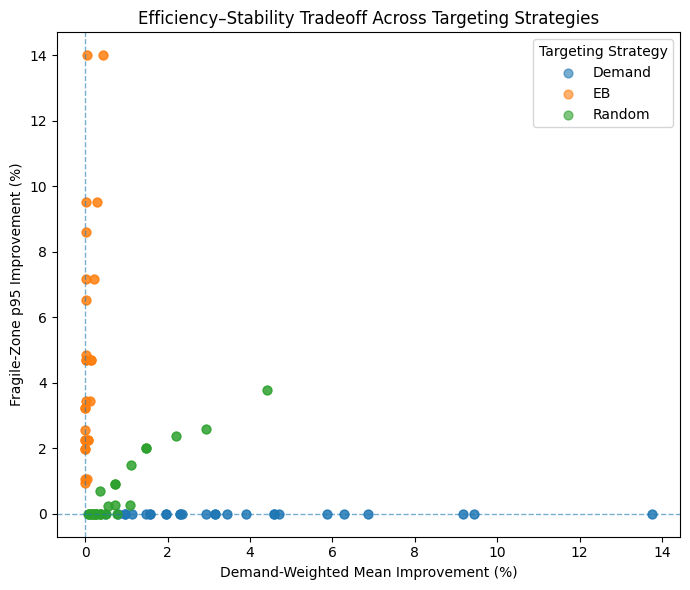

In [22]:
plot_df = results.copy()

plt.figure(figsize=(7, 6))

for strategy, g in plot_df.groupby("strategy"):
    plt.scatter(
        g["dw_mean_improvement_pct"],
        g["fragile_zone_p95_improvement_pct"],
        label=strategy,
        alpha=0.6,
        s=40
    )

plt.xlabel("Demand-Weighted Mean Improvement (%)")
plt.ylabel("Fragile-Zone p95 Improvement (%)")
plt.title("Efficiency–Stability Tradeoff Across Targeting Strategies")

plt.axhline(0, linestyle="--", linewidth=1, alpha=0.6)
plt.axvline(0, linestyle="--", linewidth=1, alpha=0.6)

plt.legend(title="Targeting Strategy")
plt.tight_layout()
plt.show()


> Figure 7. Each point represents a simulated policy scenario under a fixed supply budget, plotting demand-weighted average congestion improvement against fragile-zone tail risk reduction. Demand-based targeting prioritizes efficiency gains by concentrating resources in high-volume zones, while Empirical Bayes–based targeting achieves substantially larger reductions in extreme congestion within structurally fragile zones. Random targeting serves as a null benchmark and underperforms informed strategies except at very large budgets. The plot illustrates a clear efficiency–stability tradeoff, with no single strategy dominating across objectives. Random targeting serves as a null benchmark. Its consistently weaker performance at small and moderate budget levels indicates that observed gains under demand- and EB-based targeting are driven by informed zone selection rather than by uniform supply expansion alone.

## Final Thoughts

This analysis uses a stylized counterfactual simulation to evaluate how targeted supply interventions affect congestion dynamics across New York City taxi zones. By modeling congestion reductions as multiplicative improvements during high-stress regimes, the framework isolates how where supply is allocated shapes system outcomes, holding total policy budget fixed.

A central finding is that no single targeting strategy dominates across objectives. Demand-based targeting consistently maximizes demand-weighted average congestion improvements by concentrating resources in the busiest zones, where marginal improvements affect a large volume of trips. However, this strategy provides limited benefit to zones that experience persistent breakdown despite lower aggregate demand.
In contrast, Empirical Bayes–based targeting prioritizes zones with structurally high breakdown propensity. While this approach produces modest gains in citywide averages, it substantially reduces extreme congestion within fragile zones and delivers larger improvements when outcomes are weighted by structural vulnerability. These gains are particularly evident in tail-risk metrics, highlighting EB’s strength as a stability- and risk-mitigation policy rather than a throughput-maximizing one.

Random targeting serves as a null benchmark and consistently underperforms informed strategies at moderate budget levels, demonstrating that observed gains are driven by targeted allocation rather than uniform supply expansion alone.

Taken together, the results illustrate a clear efficiency–stability tradeoff. Policies optimized for average system performance differ from those optimized for robustness and risk reduction, and the appropriate targeting strategy depends on the policymaker’s objective. This framework provides a transparent way to quantify those tradeoffs and can be extended to richer behavioral or equilibrium models in future work.